# **Data Preparation**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Load data
data = pd.read_excel('/content/DATA 2020-2025.xlsx')
data

,TANGGAL,Prec
0,01-01-2020,14.0
1,02-01-2020,15.1
2,03-01-2020,2.7
3,04-01-2020,32.8
4,05-01-2020,3.7
...,...,...
1945,26-04-2025,44.8
1946,27-04-2025,5.3
1947,28-04-2025,0.0
1948,29-04-2025,0.0


In [ ]:
# Split data
n = len(data)
train_size = int(0.8 * n)
train = data.iloc[:train_size].copy()
test = data.iloc[train_size:].copy()

Data dibagi menjadi data train dan data test, dengan perbandingan data train 80% dan data test 20%.

In [ ]:
# Memastikan format 'TANGGAL' sudah sesuai
train['TANGGAL'] = pd.to_datetime(train['TANGGAL'], format='%d-%m-%Y')

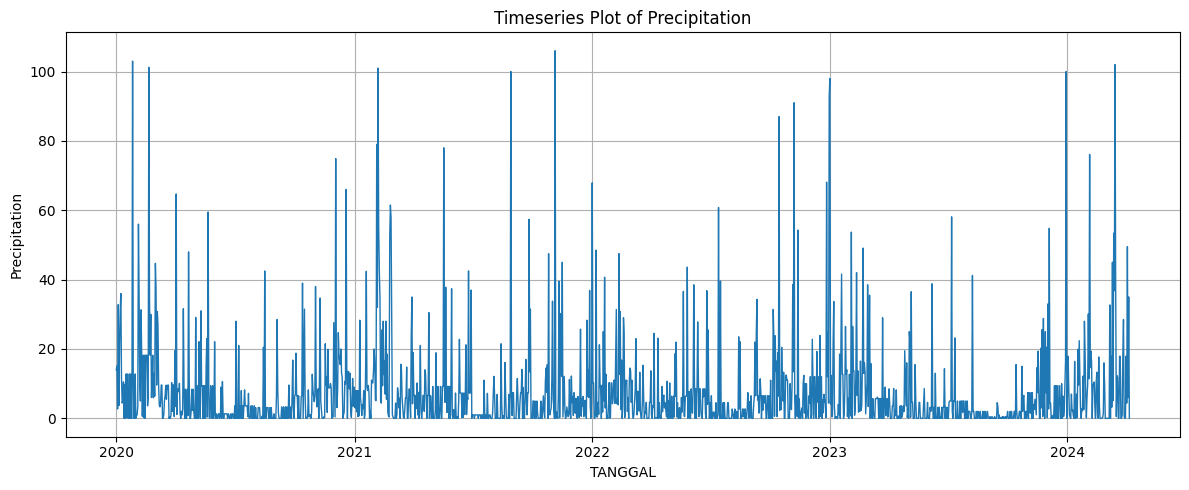

In [ ]:
# Timeseries Plot
plt.figure(figsize=(12, 5))
plt.plot(train['TANGGAL'], train['Prec'], linewidth=1)

# X-axis hanya menunjukkan tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Timeseries Plot of Precipitation')
plt.xlabel('TANGGAL')
plt.ylabel('Precipitation')
plt.grid(True)
plt.tight_layout()
plt.show()

Data di atas tidak menunjukkan bentuk yang stasioner, terutama stasioner terhadap varians, maka dari perlu dilakukan pengecekan kembali dan transformasi untuk mempersiapkan data agar dapat digunakan dalam pemodelan ARIMA.

# **Cek Stasioneritas**

**Stasioneritas terhadap varians**

In [ ]:
# Cek apakah train terdapat nilai 0
int((train['Prec'] == 0).sum())

461

Terdapat 461 baris yang bernilai 0, maka tidak dapat melakukan transformasi menggunakan boxcox 1 parameter, diperlukan trasnformasi menggunakan boxcox 2 parameter

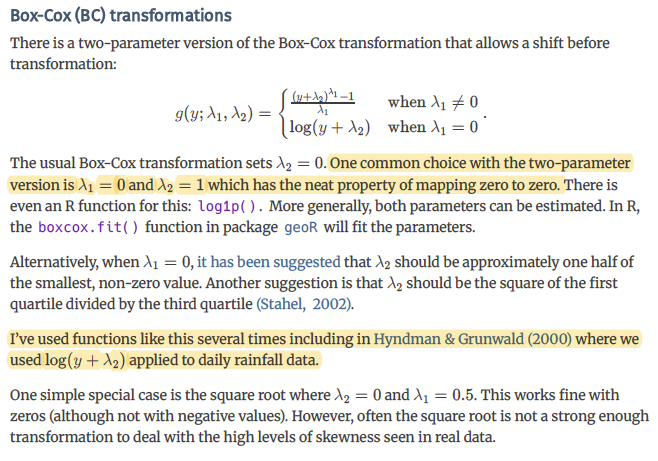

Source: <br>
https://robjhyndman.com/hyndsight/transformations/ <br>
https://robjhyndman.com/papers/rainfall.pdf (Hyndman & Grunwald, 2000) <br>
 <br>
note: Di link kedua, transformasi tidak dilakukan untuk mempersiapkan data sebelum ARIMA


In [ ]:
# Transformasi boxcox 2 parameter
train.loc[train['Prec'].index, 'Prec_trans'] = np.log(train['Prec'] + 1) #asumsi λ1 = 0 dan λ2 = 1

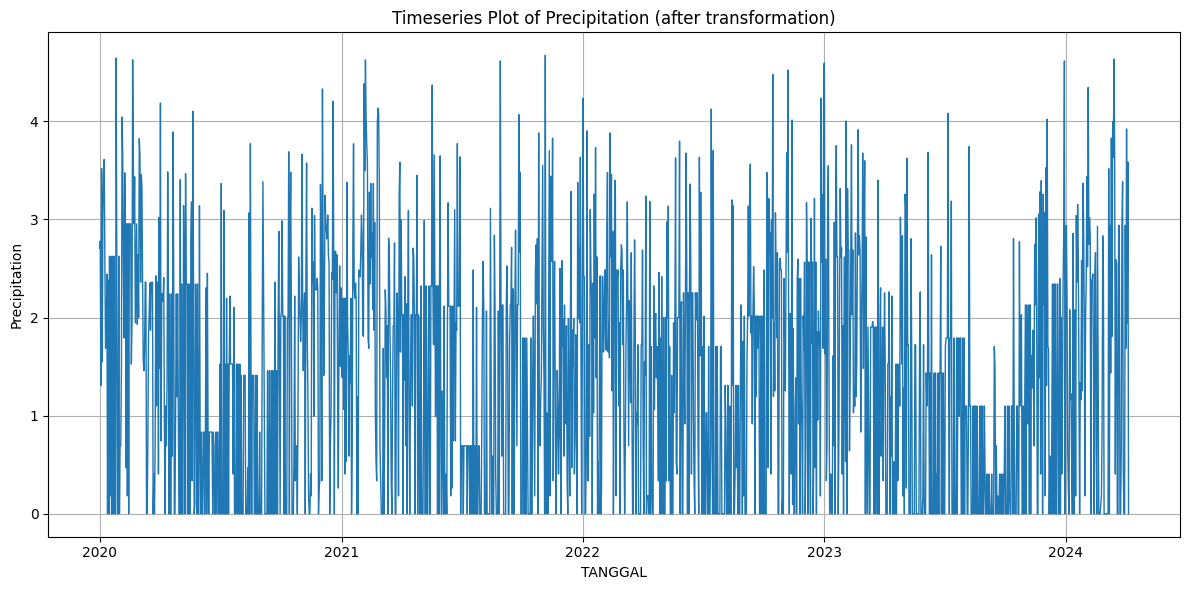

In [ ]:
# Timeseries hasil transformasi
plt.figure(figsize=(12, 6))
plt.plot(train['TANGGAL'], train['Prec_trans'], linewidth=1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Timeseries Plot of Precipitation (after transformation)')
plt.xlabel('TANGGAL')
plt.ylabel('Precipitation')
plt.grid(True)
plt.tight_layout()
plt.show()

**Stasioneritas terhadap mean**

In [ ]:
# ADF Test
result = adfuller(train['Prec_trans'])
print('ADF Statistic:', f"{result[0]:.4g}")
print('p-value:', f"{result[1]:.4g}")

ADF Statistic: -5.576
p-value: 1.43e-06




> H0 : Data tidak stasioner terhadap mean <br>
> H1 : Data stasioner terhadap mean




Dengan α = 0,05, maka dinyatakan p-value < α sehingga H0 ditolak. Artinya, data hasil transformasi boxcox sudah stasioner terhadap mean dan tidak diperlukan differencing pada data. Pada pemodelan ARIMA, akan digunakan d = 0.

**Penentuan Model ACF & PACF**

Model ARIMA ditentukan dari lag yang signifikan di plot ACF dan PACF.
*   ACF menentukan q
*   PACF menentukan p

Karena data berupa harian, maka akan dilihat 30 lag pada plot ACF dan PACF.


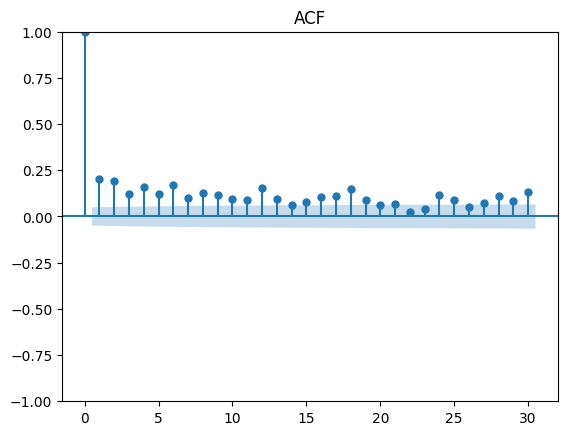

In [ ]:
# ACF Plot
plot_acf(train['Prec_trans'], lags=30)
plt.title('ACF')
plt.show()

Diagram ACF menunjukkan bahwa dari 30 lag pertama, sebagian besar lag melewati garis signifikansi sehingga dinyatakan bahwa beberapa lag signifikan.

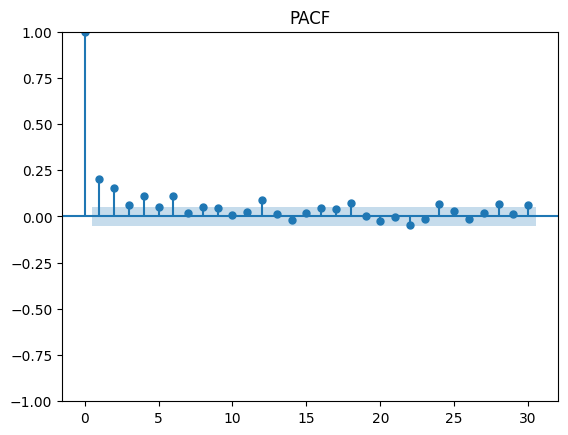

In [ ]:
# PACF Plot
plot_pacf(train['Prec_trans'], lags=30)
plt.title('PACF')
plt.show()

Diagram ACF menunjukkan bahwa dari 30 lag pertama, beberapa lag melewati garis signifikansi sehingga dinyatakan bahwa beberapa lag signifikan.

Jika merujuk pada hasil PACF dan ACF, model awal yang terbentuk akan sangat kompleks. Namun, model ARIMA merupakan parsimonious modeling (model yang lebih sederhana lebih cenderung memberikan hasil yang lebih baik), maka agar model tidak terlalu kompleks akan diasumsikan hanya 5 lag pertama yang signifikan. Jadi, model awal yg akan digunakan adalah ARIMA(5,0,5). Selanjutnya dilakukan pemodelan dengan total ada sebanyak 35 model. Berikut kombinasinya.

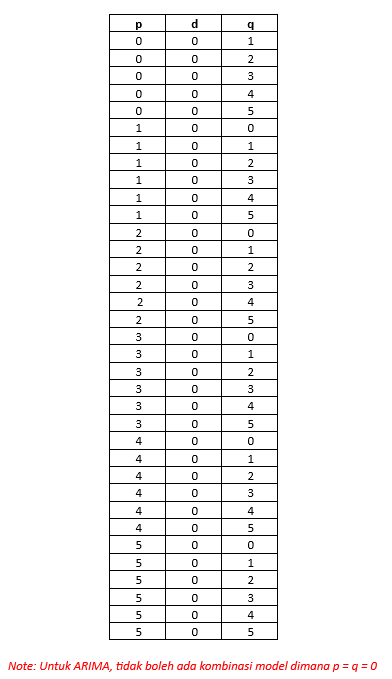


**Model ARIMA**

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Fungsi untuk menandakan '*' pada p-value yang signifikan
def get_significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

In [ ]:
# Loop pemodelan ARIMA untuk model awal p = 6, d= 0, dan q = 6
for p in range(6):
    for q in range(6):
        if not (p == 0 and q == 0):
            try:
                print(f"\n{'='*50}")
                print(f"Model ARIMA({p}, 0, {q})")
                print(f"{'='*50}")

                # Fit model ARIMA
                model = ARIMA(train['Prec_trans'], order=(p, 0, q))
                result = model.fit()

                # Menampilkan tabel koefisien dengan simbol signifikan
                summary_df = result.summary().tables[1].as_html()
                df_coef = pd.read_html(summary_df, header=0, index_col=0)[0]
                df_coef['Signif'] = df_coef['P>|z|'].apply(get_significance_stars)

                print(df_coef)
                print("-" * 60)

            except Exception as e:
                print(f"Gagal fit ARIMA({p}, 0, {q}): {e}")


Model ARIMA(0, 0, 1)
          coef  std err       z  P>|z|  [0.025  0.975] Signif
const   1.3824    0.038  36.282    0.0   1.308   1.457    ***
ma.L1   0.1565    0.025   6.172    0.0   0.107   0.206    ***
sigma2  1.4547    0.075  19.421    0.0   1.308   1.602    ***
------------------------------------------------------------

Model ARIMA(0, 0, 2)
          coef  std err       z  P>|z|  [0.025  0.975] Signif
const   1.3826    0.042  32.697    0.0   1.300   1.465    ***
ma.L1   0.1645    0.025   6.480    0.0   0.115   0.214    ***
ma.L2   0.1411    0.025   5.744    0.0   0.093   0.189    ***
sigma2  1.4208    0.072  19.667    0.0   1.279   1.562    ***
------------------------------------------------------------

Model ARIMA(0, 0, 3)
          coef  std err       z  P>|z|  [0.025  0.975] Signif
const   1.3826    0.044  31.371  0.000   1.296   1.469    ***
ma.L1   0.1630    0.026   6.340  0.000   0.113   0.213    ***
ma.L2   0.1456    0.025   5.827  0.000   0.097   0.195    ***
ma.L3 

Dihasilkan **7 model** yang seluruh parameternya signifikan (terlihat dari nilai P>|z| yang kurang dari 0,05 dan ditandai dengan lambang “*”).

**Model yang seluruh parameternya signifikan:**
*   ARIMA(0, 0, 1)
*   ARIMA(0, 0, 2)
*   ARIMA(0, 0, 3)
*   ARIMA(0, 0, 4)
*   ARIMA(1, 0, 1)
*   ARIMA(2, 0, 0)
*   ARIMA(3, 0, 0)

# **Diagnostic Checking**

In [ ]:
# Daftar model ARIMA
model_codes = ['001', '002', '003', '004', '101', '200', '300']
model_orders = {f"ARIMA{tuple(map(int, code))}": tuple(map(int, code)) for code in model_codes}

# Fit model ARIMA
model_results = {}

for name, order in model_orders.items():
    try:
        model = sm.tsa.ARIMA(train['Prec_trans'], order=order).fit()
        model_results[name] = model
    except Exception as e:
        print(f"{name} gagal di-fit: {e}")

In [ ]:
# Fungsi diagnostic checking
def check_diagnostics(model_result):
    res = model_result.resid
    lb = acorr_ljungbox(res, lags=[10], return_df=True)
    lb_sq = acorr_ljungbox(res**2, lags=[10], return_df=True)
    jb_stat, jb_pval = jarque_bera(res)[:2]

    return {
        "Ljung-Box pval": lb.iloc[0]["lb_pvalue"],
        "Ljung-Box² pval": lb_sq.iloc[0]["lb_pvalue"],
        "Jarque-Bera pval": jb_pval,
    }


> **UJI AUTOKORELASI** <br>
> H0 : Tidak terjadi autokorelasi pada residual <br>
> H1 : Terjadi autokorelasi pada residual




> **UJI HOMOSKEDASTISITAS** <br>
> H0 : Residual bersifat homoskedastik <br>
> H1 : Residual tidak bersifat homoskedastik


> **UJI NORMALITAS** <br>
> H0 : Residual berdistribusi normal <br>
> H1 : Residual tidak berdistribusi normal


Model dikatakan memenuhi kriteria diagnostic checking apabila tidak terdapat autokorelasi pada residual, residual bersifat homoskedastisitas, serta residual berdistribusi normal. Maka, model yang baik adalah model yang tidak menolak H0 <br>(menghasilkan p-value > α, dengan α = 0,05)

In [ ]:
# Hasil diagnostic checking
diagnostics = {
    name: check_diagnostics(result)
    for name, result in model_results.items()
}

# Output dalam bentuk tabel
diagnostics_df = pd.DataFrame(diagnostics).T
print(diagnostics_df.round(4))

                Ljung-Box pval  Ljung-Box² pval  Jarque-Bera pval
ARIMA(0, 0, 1)          0.0000           0.0003               0.0
ARIMA(0, 0, 2)          0.0000           0.0019               0.0
ARIMA(0, 0, 3)          0.0000           0.0007               0.0
ARIMA(0, 0, 4)          0.0000           0.0024               0.0
ARIMA(1, 0, 1)          0.1326           0.0000               0.0
ARIMA(2, 0, 0)          0.0000           0.0005               0.0
ARIMA(3, 0, 0)          0.0000           0.0002               0.0


Dari hasil diagnostic checking, terlihat bahwa model yang memenuhi paling banyak asumsi pada diagnostic checking adalah model ARIMA(1,0,1). Model ini memenuhi uji autokorelasi. tetapi tidak untuk Uji homoskedastik dan uji normalitas. Walaupun model ini adalah model terbaik, tetapi terdapat indikasi bahwa model tidak akan dapat memberikan hasil forecast yang baik.

# **Model Terbaik**

Model ARIMA terbaik untuk Forecasting menggunakan data ini adalah model ARIMA(1,0,1)

In [ ]:
best_model = sm.tsa.ARIMA(train['Prec_trans'], order=(1, 0, 1)).fit()

# **Forecasting**

In [ ]:
# Forecast
fc = best_model.forecast(steps=len(test))
fc

,predicted_mean
1560,1.679956
1561,1.668541
1562,1.657587
1563,1.647075
1564,1.636987
...,...
1945,1.397057
1946,1.397057
1947,1.397057
1948,1.397057


In [ ]:
# Mengembalikan nilai setelah transformasi
forecast_inv = np.exp(fc) - 1
forecast_inv

,predicted_mean
1560,4.365318
1561,4.304423
1562,4.246636
1563,4.191772
1564,4.139661
...,...
1945,3.043284
1946,3.043284
1947,3.043284
1948,3.043284


In [ ]:
# Perbandingan data asli dengan data ramalan
result_df = pd.DataFrame({
    'Date': test['TANGGAL'].values,
    'Actual': test['Prec'].values,
    'Forecast': forecast_inv
})

result_df.head()

,Date,Actual,Forecast
1560,06-04-2024,96.6,4.365318
1561,07-04-2024,0.0,4.304423
1562,08-04-2024,43.0,4.246636
1563,09-04-2024,9.0,4.191772
1564,10-04-2024,0.5,4.139661


--END--

In [ ]:
# 1. Hitung fitted value ARIMA untuk training
fitted_train = np.expm1(best_model.fittedvalues)
residual_train = train['Prec'].values - fitted_train.values

In [ ]:
# 2. Forecast testing sudah kamu buat: forecast_inv
residual_test = test['Prec'].values - forecast_inv.values

In [ ]:
# 3. Normalisasi residual training
from sklearn.preprocessing import MinMaxScaler  # ← tambahkan ini di awal jika belum ada
scaler = MinMaxScaler()
residual_train_scaled = scaler.fit_transform(residual_train.reshape(-1, 1))


In [ ]:
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# 4. Dataset LSTM
time_step = 10
X_train, y_train = create_dataset(residual_train_scaled, time_step)


In [ ]:
# 5. LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(90, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=400, batch_size=32)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0206
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0135
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0137
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0140
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0134
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0145
Epoch 8/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0134
Epoch 9/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0136
Epoch 10/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0138
Epoch 11/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0134
Epoch 12/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0152
Epoch 13/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0138
Epoch 14/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134
Epoch 15/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - lo

In [ ]:
# 6. Siapkan input residual testing
residual_test_scaled = scaler.transform(residual_test.reshape(-1, 1))
X_test, _ = create_dataset(residual_test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# 7. Prediksi residual testing
residual_pred_scaled = model.predict(X_test)
residual_pred = scaler.inverse_transform(residual_pred_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
# 8. Hybrid forecast
forecast_test = forecast_inv.values[time_step:]
actual_test = test['Prec'].values[time_step:]
dates_test = test['TANGGAL'].values[time_step:]
hybrid_forecast = forecast_test + residual_pred.flatten()

In [ ]:
# 9. Buat DataFrame hasil
hybrid_df = pd.DataFrame({
    'Date': dates_test,
    'Actual': actual_test,
    'Hybrid_Forecast': hybrid_forecast
})
hybrid_df

,Date,Actual,Hybrid_Forecast
0,16-04-2024,4.7,8.948352
1,17-04-2024,18.1,5.628112
2,18-04-2024,3.0,1.491063
3,19-04-2024,10.7,15.074435
4,20-04-2024,0.1,7.707641
...,...,...,...
375,26-04-2025,44.8,8.798927
376,27-04-2025,5.3,7.261785
377,28-04-2025,0.0,9.771597
378,29-04-2025,0.0,12.551545


In [ ]:
# 10. Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_test, hybrid_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_test, hybrid_forecast)
mape = np.mean(np.abs((actual_test - hybrid_forecast) / actual_test)) * 100
smape = 100 * np.mean(2 * np.abs(hybrid_forecast - actual_test) / (np.abs(actual_test) + np.abs(hybrid_forecast)))

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('SMAPE:', smape)

MSE: 348.88820303006605
RMSE: 18.67854927530685
MAE: 12.196218600388269
MAPE: inf
SMAPE: 152.376392898672


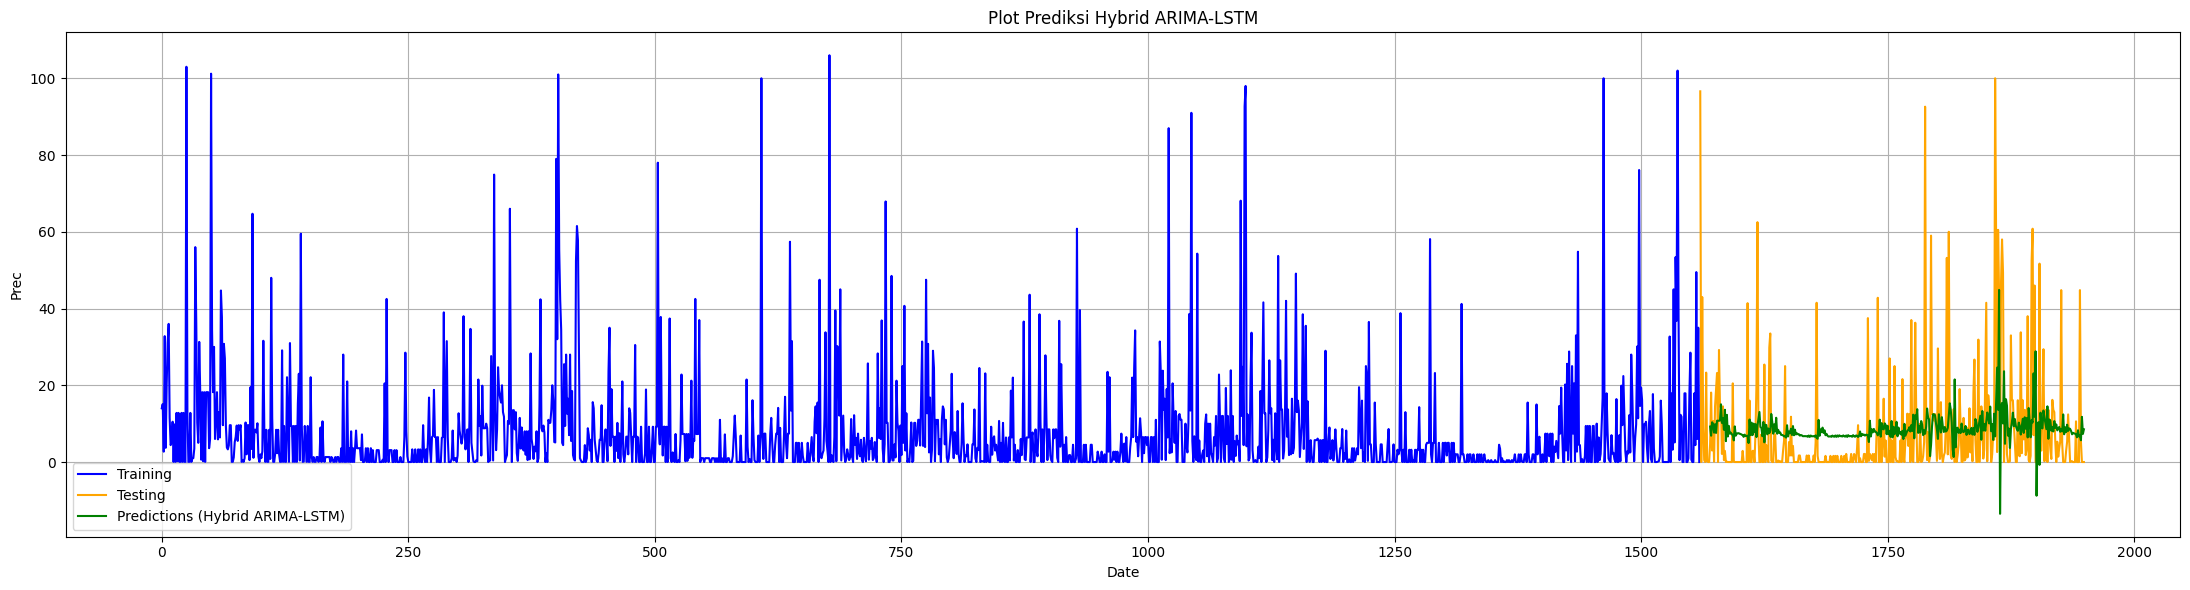

In [ ]:
import matplotlib.pyplot as plt

# Gabungkan kembali semua data untuk plotting
total_data = pd.concat([train[['TANGGAL', 'Prec']], test[['TANGGAL', 'Prec']]])
total_data = total_data.reset_index(drop=True)
total_data['index'] = total_data.index

# Atur indeks prediksi hybrid agar sesuai di time axis
hybrid_df = hybrid_df.reset_index(drop=True)
hybrid_df['index'] = hybrid_df.index + len(train) + time_step  # hybrid dimulai setelah training + window

# Plot
plt.figure(figsize=(22, 6))  # bisa sesuaikan ukuran
plt.plot(total_data.index[:len(train)], train['Prec'], label='Training', color='blue')
plt.plot(total_data.index[len(train):], test['Prec'], label='Testing', color='orange')
plt.plot(hybrid_df['index'], hybrid_df['Hybrid_Forecast'], label='Predictions (Hybrid ARIMA-LSTM)', color='green')

plt.xlabel('Date')
plt.ylabel('Prec')
plt.title('Plot Prediksi Hybrid ARIMA-LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


beda code dan beda input model pada LSTM